# This ipynb tries to duplicate the result by Chad DeChant on MNIST small 
(http://llcao.net/cu-deeplearning15/programming_problem.html).
There are two key components in Chad's work: (1)RMSprop and (2) dropout.

import sys
sys.path.append('../../')
from layer_for_theano import *

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import cPickle
import numpy as np
import gzip

import time

class dataset_mnist_small_3d:
    def __init__(self):
        if 0: # no requirement for gzip, but big file
            f = open('mnist_14x14.pkl', 'rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()
        else: # requiring gzip           
            f = gzip.open('mnist_14x14.pkl.gz','rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()

        xs_tr, ys_tr = train_set
        xs_val, ys_val = valid_set
        xs_te, ys_te = test_set
        
        self.xs_tr = xs_tr.reshape(xs_tr.shape[0],1,14,14)
        self.xs_te = xs_te.reshape(xs_te.shape[0],1,14,14)
        self.xs_val = xs_val.reshape(xs_val.shape[0],1,14,14)       

        self.ys_tr =  ys_tr.astype(np.int32)
        self.ys_val = ys_val.astype(np.int32)
        self.ys_te =  ys_te.astype(np.int32)

t0 = time.time()
        
ds =  dataset_mnist_small_3d()  
print 'load dataset in %.1f secs' % (time.time()-t0)

print ds.xs_tr.shape


load dataset in 2.8 secs
(50000L, 1L, 14L, 14L)


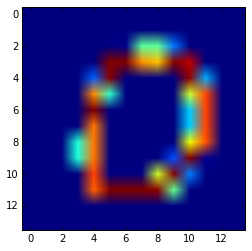

In [15]:
plt.imshow(ds.xs_te[10,0])
plt.show()

In [20]:
from sgd_for_theano import *
class cnn_small(tt_sgd_model):
    def __init__(self):
        #784
        #dim = 196
        nc = 10

        self.layers = []
        self.layers += [Input2DLayer(500, 1, 14, 14)]

        nonlinearfunc = T.tanh #T.nnet.sigmoid #rectify #rectify
        print 'nonlinear activation function = ', nonlinearfunc
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[20,1,3,3], activation=nonlinearfunc)]
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[50,20,3,3], activation=nonlinearfunc)]
        
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = 500,  activation = T.tanh)]
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = nc,  activation = None)]
        
        self.layers += [FlattenLayer(self.layers[-1])]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 900)]
        
        self.layers +=  [ SoftmaxLayer(self.layers[-1])]

        target = T.ivector('target')
        output_eval = self.layers[-1].output()
        self.cost_eval = mcloss_negli(output_eval, target)
        self.err_eval = mc_error(output_eval, target)
        self.validate_model = theano.function([self.layers[0].input, target], self.err_eval)
        self.cost_model = theano.function([self.layers[0].input, target], self.cost_eval)

        output_tr = self.layers[-1].output(dropout_training=True)
        self.cost_tr = mcloss_negli(output_eval, target)

        #learning_rate = 0.13
        learning_rate = 0.05
        #all_para = all_parameters(self.layers[-1])
        all_para = self.get_all_parameters()
        updates = gen_updates_sgd(self.cost_tr, all_para, learning_rate)
        self.train_model = theano.function([self.layers[0].input, target], self.cost_tr, updates=updates)

model = cnn_small()

if 1: #unit test
    import sys
    model._unit_test(ds.xs_tr[0:100], ds.ys_tr[0:100])
    #sys.exit(0)

nonlinear activation function =  Elemwise{tanh,no_inplace}
before training, err= 1.0
now training, cost =  6.83060387473
after training, err= 0.72


In [ ]:
best_err, best_model,err_list_val, err_list_tr =  sgd_batch(model, ds.xs_tr, ds.ys_tr, ds.xs_te, ds.ys_te, batch_size=600, n_epochs=10, verbose=2)

6.35079183686 6.08741334625 5.97214347787 5.92120698185 5.8962004277 5.87484880497 5.85892059507 5.84518480397 5.83199467145 5.81919310719 5.80521130336 5.79331100288 

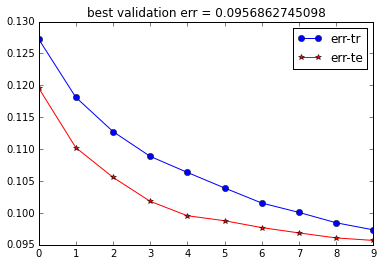

In [17]:

plt.plot(err_list_tr,'bo-',label='err-tr')
plt.plot(err_list_val,'r*-',label='err-te')
plt.legend()
plt.title('best validation err = ' + str(best_err))
plt.show()